# GDELT initial findings from articles in January 2020

Author: Mike Pesavento  
Email: mike@peztek.com  
Started: 2020-06-29  
Last change: 2020-07-08


This report isolates and mines the [GDELT collection of news articles](https://blog.gdeltproject.org/a-new-contextual-dataset-for-exploring-climate-change-narratives-6-3m-english-news-urls-with-contextual-snippets-2015-2020/) containing information on climate change.  This collection consists of roughly 1 million articles spanning 5 years, from 2015 to 2020.

As a preliminary study, we use the (Argument Unit Recognition and Classification)[https://aaai.org/Papers/AAAI/2020GB/AAAI-TrautmannD.7498.pdf] (RESTful API)[https://api.argumentsearch.com/en/doc] to scrape sentences from the given articles and classify them as being PRO (for) or CONTRA (against) the given topic key words.

For the purposes here, we will focus on the keyword `climate change`, and use the API's similarity score based on the [`word2vec`](https://en.wikipedia.org/wiki/Word2vec) class of models for identifying word similarity. 


## On Arguments and Claims
A significant point of this study is to examine the accuracy of the ArgText API, to see how accurate it is in classifying whether or not a sentence contains an arugment or claim. However, identifying a "claim" depends on the definition for a claim.

Here, we define a **claim** as:
lorem ipsum

An **argument** is:
lorem ipsum


These definitions are from The Society Library's "Making Arguments - A Quick Guide" document.

## Goals

1. Use the API to extract sentences from the first 10000 URLs, along with the model's classification of PRO or CONTRA for each sentence
1. Examine the distribution of articles FOR and AGAINST the given topic. If an article has more sentences PRO than CONTRA we claim the article is FOR the topic, and vice versa.
1. Spot check the accuracy of the API model. This requires manual review of given sentences to see if they contain an argument or claim



In [1]:
# reload local package definitions for each cell
%load_ext autoreload
%autoreload 2

In [40]:
import os
import time

from dotenv import find_dotenv, load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from arg_mine import DATA_DIR, FIGURES_DIR
from arg_mine.data import loaders, labelers
from arg_mine.api import classify, auth, session, errors
from arg_mine import utils

SEED = 12345

sns.set_style("whitegrid")

In [3]:
# load the 2020 context snippet, for access later
csv_datapath = os.path.join(DATA_DIR, "raw", "2020-climate-change-narrative")
csv_filepath = os.path.join(csv_datapath, "WebNewsEnglishSnippets.2020.csv")

url_df = loaders.get_gdelt_df(csv_filepath)

INFO:2020-07-14 00:49:09,055:arg_mine.data.loaders: reading data from: /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2020.csv


In [59]:
start_time = time.time()
data_processed_project = "gdelt-climate-change-docs"
base_path = os.path.join(DATA_DIR, "processed", data_processed_project)
docs_df = loaders.concat_csvs("gdelt_2020_docs_docs*.csv", base_path)

print("data load and concatenation took {:0.1f} s".format(time.time() - start_time))

data load and concatenation took 0.2 s


## First finding: data attrition & descriptive stats
As expected, we find that there is some loss of data from the URL extraction. For example, some URLs point to articles that are no longer accessible, returning a 404 (page not found) error. This accounts for the overwhelming majority of the missing data.

In [5]:
total_number_articles = 10000  # from the current extraction
percent_data_loss = (1 - docs_df.shape[0]/total_number_articles) * 100
print("Number of valid articles: {}/{}  ({:0.2f}% data loss)".format(
    docs_df.shape[0],
    total_number_articles,
    percent_data_loss
))

Number of valid articles: 7460/10000  (25.40% data loss)


In [6]:
sentence_ct_cols = ['total_classified_sentences', 'total_arguments', 'total_non_arguments', 'total_contra_arguments', 'total_pro_arguments']

print("Total number of classified sentences: {}".format(docs_df['total_classified_sentences'].sum()))

docs_df[sentence_ct_cols].describe()

Total number of classified sentences: 314263


,total_classified_sentences,total_arguments,total_non_arguments,total_contra_arguments,total_pro_arguments
count,7460.000000,7460.000000,7460.000000,7460.000000,7460.000000
mean,42.126408,9.134718,32.991689,5.819839,3.314879
std,68.995005,11.436949,62.894992,8.274904,4.718278
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2.000000,12.000000,1.000000,0.000000
50%,30.000000,6.000000,21.000000,3.000000,2.000000
75%,46.000000,13.000000,35.000000,8.000000,5.000000
max,2535.000000,328.000000,2468.000000,238.000000,93.000000


## Distribution of number of sentences per document

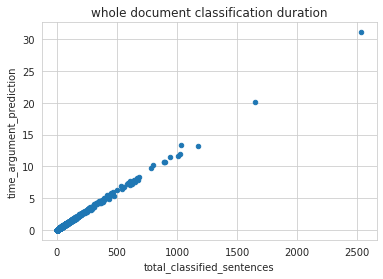

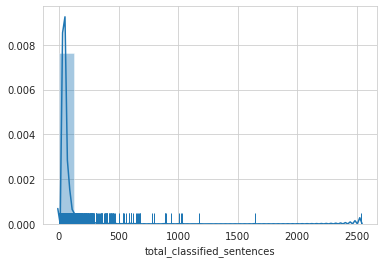

In [37]:
# time for classification as a function of number of sentences
docs_df.plot.scatter(x='total_classified_sentences', y='time_argument_prediction')
_ = plt.title("whole document classification duration")

plt.figure()
sns.distplot(docs_df['total_classified_sentences'], bins=20, kde=True, rug=True)


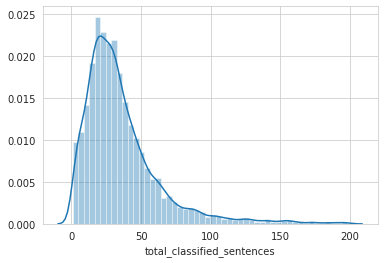

In [38]:
docs_cropped = docs_df[docs_df['total_classified_sentences'] < 200]

sns.distplot(docs_cropped['total_classified_sentences'], bins=50, kde=True, rug=False)


## Distribution of argument sentences

What is the density of sentences that are making an argument for or against the topic, given all of the classified sentences?

In [39]:
docs_df["pct_arg"] = docs_df.total_arguments / docs_df.total_classified_sentences

# estimate if doc is PRO or CON
docs_df["is_pro"] = docs_df['total_pro_arguments'] > docs_df['total_contra_arguments']

Text(0, 0.5, '# of documents')

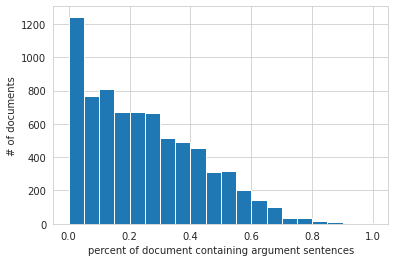

In [8]:
docs_df["pct_arg"].hist(bins=20)
plt.xlabel("percent of document containing argument sentences")
plt.ylabel("# of documents")

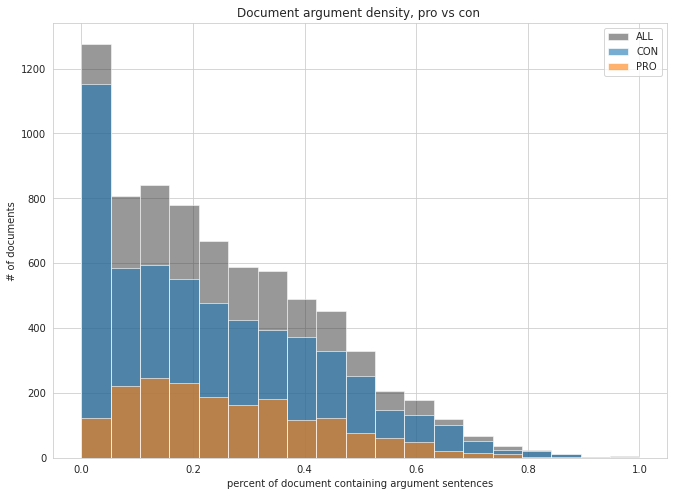

In [9]:
fig, ax = plt.subplots(figsize=(11, 8))
alpha=0.6
bins=np.linspace(0, 1, 20)
plt.hist(docs_df["pct_arg"], bins=bins, color=[0.2, 0.2, 0.2], alpha=0.5, label="ALL")
plt.hist(docs_df.loc[~docs_df["is_pro"], "pct_arg"], bins=bins, alpha=alpha, label="CON")
plt.hist(docs_df.loc[docs_df["is_pro"], "pct_arg"], bins=bins, alpha=alpha, label="PRO")
plt.xlabel("percent of document containing argument sentences")
plt.ylabel("# of documents")
plt.title("Document argument density, pro vs con ")
plt.legend()
fig.savefig(os.path.join(FIGURES_DIR, "doc_arg_density_1000docs_Jan2020.png"))

## Number of arguments by hostname

In [10]:
docs_df['netloc'] = utils.get_url_hostnames(docs_df.url)

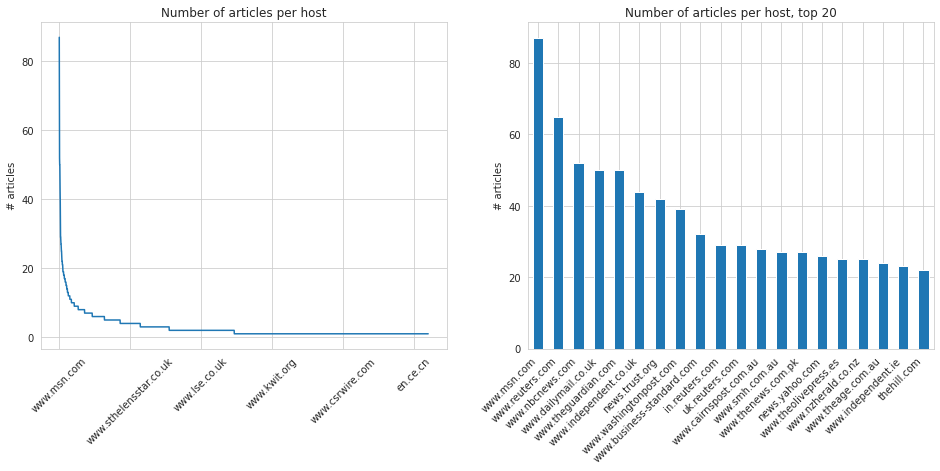

In [11]:
netloc_hist = docs_df.netloc.value_counts()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
netloc_hist.plot(kind="line", rot=45, ax=ax[0])
ax[0].set_ylabel("# articles")
_ = ax[0].set_title("Number of articles per host")

# look at top articles
top_n = 20
netloc_hist.iloc[:top_n].plot(kind="bar", ax=ax[1])
ax[1].set_xticklabels(netloc_hist.iloc[:top_n].index.values, rotation=45, ha='right')
ax[1].set_ylabel("# articles")
_ = ax[1].set_title("Number of articles per host, top {}".format(top_n))

In [12]:
# find the quantile boundaries?

# Spot-check on arguments
How do we check whether a sentence is a claim or an argument?

We have docs on this!
An argument is a combination of claims (2 or more). One of those claims is the premise, which justifies the conclusion.

Two types of statements. One is implied ("Climate change is occuring")

Argument is creating reasoning to justify conclusion.

A claim is any assertion of truth, fact or opinion, right or wrong. It implies the truth of something.

## What i need to do
Spot check is to detect whether a sentence is a argument or claim.
reason for argument is not valid if claim.

Get examples of claim and arg extraction from Jamie?
Read `Making Arguments` guide

Want to know accuracy of the API.
if is accurate at pulling out arguments & claims

We may have a labeled dataset as well
done so line by line!

Sentences are listed because claim or arugment can be derived from them.

* Jamie will share labeled dataset
There is a tag added that has "implied". These need to be omitted as a label.



In [66]:
docs_sampled = docs_df[docs_df.index < 999].sample(n=30, random_state=SEED)
doc_ids = docs_sampled.doc_id.values

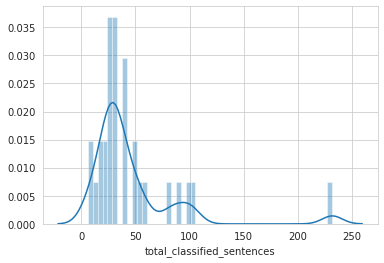

In [57]:
sns.distplot(docs_sampled['total_classified_sentences'], bins=50, kde=True, rug=False)

In [74]:
docs_sampled['total_classified_sentences'].sum()

1365

In [86]:
sentences_full_df = loaders.load_processed_csv("gdelt_2020_sentences_docs0-999.csv", data_processed_project)

INFO:2020-07-14 20:36:41,754:arg_mine.data.loaders: reading data from: /opt/workspace/data/processed/gdelt-climate-change-docs/gdelt_2020_sentences_docs0-999.csv


In [75]:
# filter the sentences to only our subsampled dataset
sentences_df = sentences_full_df[sentences_full_df.doc_id.isin(doc_ids)]
sentences_df.shape

(70, 11)

In [76]:
doc_ids

array(['a9aa004b014fb374b2b78466ec7b160e',
       'dac8f68ce3e6484ff1b365936d0c2e06',
       'f62f3ca5701621d25e4d00a172b3c1dd',
       '7afe30e30ddec5044304918fbd7a3168',
       '26b55485bcb8dac1eb53ecfcbd773d1d',
       'd874cd694e02f1dfeea86cfdaa280df3',
       '42e67846999006afb9b57e06a0e9b236',
       'be8ce0e1e5aebaa11ca984045a5ee110',
       '174b9e69c85f8ddbff3dbed7c7dd3716',
       '6250768459aa0018a1153a6b672a7af6',
       '1f14e45dcf9eaa192a2898eb5a750fc8',
       '992c8e9ab7870226891a677e0f421f99',
       '52ea20cbeb3cb161d4cf28071cf60456',
       '90cf4d34e98d0eec0a09e9586b76d85d',
       '13e4a88f03e9e94953a154810a835fa5',
       '4a07cb19354b6b0283228941f907df62',
       '45d577e77ad060bd45de275900e16dec',
       '8a475166807a4906ce297e1011f92aba',
       '60b54630cb911c2716a6b9e06eca8cc3',
       'ad58afe92b1d0c812a6901759c963123',
       'bfaaaeecebbdfde4982929918cfa0bac',
       '3161784d361847b29bec9885e0f5c1a6',
       '3291f458050137a38c1d3c95b0e80f40',
       'd95

In [77]:
# need to drop empty sentences!
sentences_df.dropna(subset=['sentence_original'], inplace=True)

# add the context labels
sentences_df = labelers.label_gdelt_context(url_df, docs_sampled, sentences_df)

In [78]:
sentences_df.head()

,url,doc_id,topic,sentence_id,argument_confidence,argument_label,sentence_original,sentence_preprocessed,sort_confidence,stance_confidence,stance_label,has_context,has_labeled_arg
17001,https://www.expressnews.com/opinion/commentary...,2aaa237ebff6a58293251684b6c029f6,climate change,eed9ae766f06ab84d90284588a70626d,0.003930,no argument,Opinion: Warren and Klobuchar teach the boys a...,Opinion: Warren and Klobuchar teach the boys a...,NaN,0.0,NaN,False,NaN
17002,https://www.expressnews.com/opinion/commentary...,2aaa237ebff6a58293251684b6c029f6,climate change,7498a47503e02a331a47f0ac606e8860,0.003573,no argument,"U.S. Sen. Elizabeth Warren, left, greets Sen. ...","U.S. Sen. Elizabeth Warren, left, greets Sen. ...",NaN,0.0,NaN,False,NaN
17003,https://www.expressnews.com/opinion/commentary...,2aaa237ebff6a58293251684b6c029f6,climate change,e5a26776f51474537c1090f71838a3cf,0.006567,no argument,"A month later, they are among their party’s to...","A month later, they are among their party’s to...",NaN,0.0,NaN,False,NaN
17004,https://www.expressnews.com/opinion/commentary...,2aaa237ebff6a58293251684b6c029f6,climate change,7ec27e02396a2b9e2bd18ad26df66e8e,0.003551,no argument,Photo: Justin Sullivan /Getty Images,Photo: Justin Sullivan /Getty Images,NaN,0.0,NaN,False,NaN
17005,https://www.expressnews.com/opinion/commentary...,2aaa237ebff6a58293251684b6c029f6,climate change,40187a3a650728b2d801ac3eaf40492f,0.016467,no argument,Would a female Democratic nominee have a harde...,Would a female Democratic nominee have a harde...,NaN,0.0,NaN,False,NaN


In [79]:
sentences_df[sentences_df.argument_label == classify.ArgumentLabel.ARGUMENT].shape

(13, 13)

In [80]:
sentences_df.shape

(70, 13)